# Connect Four with MCTS and Decision Tree AI

An implementation of Connect Four featuring AI players powered by **Monte Carlo Tree Search (MCTS)** and **Decision Trees**.

---

## Overview

This project offers three gameplay modes:
- **Human vs Human**
- **Human vs AI**
- **AI vs AI**

It includes two AI strategies:
- **Monte Carlo Tree Search (MCTS):** A simulation-based search algorithm.
- **Decision Tree AI:** A machine learning model trained on MCTS-generated gameplay data.

For detailed documentation, refer to the files in the [`docs/`](./docs) directory.

## Authors

- António Lanção
- Henrique Teixeira
- João Ferreira

## Introduction

This report details the development and implementation of a Connect Four game with intelligent agents. As outlined in the Artificial Intelligence 2024/2025 assignment, this project explores adversarial search strategies and decision tree learning within the context of a two-player game. Connect Four, a strategy game similar to tic-tac-toe played on a vertical grid, provides an engaging platform for investigating these AI techniques.

This work presents a Connect Four game offering three distinct gameplay modes: Human vs Human, Human vs AI, and AI vs AI. Central to the AI capabilities of this project are two distinct strategies: Monte Carlo Tree Search (MCTS), a powerful simulation-based search algorithm, and a Decision Tree AI, a machine learning model trained on gameplay data generated by the MCTS agent. The integration of these two approaches allows for a comparative analysis of their strengths and weaknesses in the domain of game playing.

This report will delve into the design and implementation of both AI agents, the process of generating training data for the decision tree, and the overall architecture of the Connect Four game. Further details regarding the project structure and implementation can be found in the files located within the docs/ directory. This project was developed collaboratively by a team of three students as part of the practical exercises for the AI course, with supplementary work conducted outside of scheduled classes.

### Connect4 Implementation

This Connect Four implementation provides a platform to explore AI game-playing strategies, specifically focusing on Monte Carlo Tree Search (MCTS). The project encompasses the game logic itself and an AI agent utilizing MCTS to determine optimal moves.

The game's foundation is built upon the `Connect4Board` class, which employs bitboards for efficient representation of the game state. This allows for optimized game operations. The `Connect4` class encapsulates the game rules and logic, and crucially, it's designed to adhere to a generic `MCTSInterface`. As detailed in the project's documentation (within the `docs/` directory), this interface promotes modularity by decoupling the MCTS algorithm from the specifics of the Connect Four game.

In essence, the `Connect4` class provides a set of methods that the MCTS algorithm uses to interact with the game. Some of the most important functions within this API include:

* `play(state: Connect4Board, action: int) -> Connect4Board`: This function is responsible for taking a game state and a player's action (a column choice) and returning the resulting new game state after the move has been made. It simulates the effect of a move on the board.
* `get_actions(state: Connect4Board) -> List[int]`: Given a game state, this function returns a list of all valid actions (i.e., available columns to play in) that a player can take.
* `is_terminal_state(state: Connect4Board, action: int) -> bool`: This function checks whether a given state, potentially resulting from a specific action, represents the end of the game (win, loss, or draw).
* `value(state: Connect4Board, action: int, player: Optional[int] = None) -> float`: This is crucial for MCTS. It evaluates the outcome of a game state. The function assigns a numerical value to the state, indicating the desirability of that state for a player. As the original document says, the expected values are -1, 0.5, and 1, representing ongoing, draw, and win, respectively.
* `get_current_player(state: Connect4Board) -> int`: This function simply returns which player's turn it is in the given game state.

These functions collectively define the rules of Connect Four in a way that the generic MCTS algorithm can understand and utilize to explore the game tree and make informed decisions.

## MCTS (Monte Carlo Tree Search)

For this algorithm we used the standard algorithm with a few key changes to speed and make it a little bit more precise in simple positions.

### MCTS Interface

The algorithm implemented uses a Python Abstract Class to serve as an interface for any two-player game. This way the behaviour of the algorithm is not tied up to the game implementation and it is easier to understand and debug. This is documented in the `docs/` directory, however in a broad sense it will ask the game data structure for the available moves in the position and then create the search tree while using other helper functions to see if it reached a final state, etc.

### Terminal State

In a similar way Minimax has a variant with alpha-beta cuts for branch cutting, we've implemented here a value for each node in the search tree named "terminal value" to determine what the best path from that node will lead to.

For example, let's say we are in a given iteration of MCTS in the expansion fase, we expand the node by iterating through the possible actions in the current state and we create a new state with the action played in a copy of the parent. Now, the algorithm calls a function from the world interface to determine the current value of this child. The expected values are: -1, which corresponds to an ongoing game, 0, a loss position for the current player, 0.5, a draw, and 1, win (note: because in Connect4 you cannot play a losing move, which is a move you play and the game ends immediately with you losing, the only possible outcomes are -1, 0.5 and 1). So if there is a child which is a win, then the previous state is a loss, in the sense that the algorithm is expecting for the other player to choose the best path possible. So, we can stop expanding this node, eliminate its children and mark its terminal state value as 0 (loss). Then we backpropagate this value until the node has no parent or we can't determine the terminal value of that node, that is the children node are draws and/or losses and/or non-terminal states. If there are no non-terminal states, the terminal value of the node is given my the maximum terminal value and then we eliminate its children. In the case the node is non-terminal or a draw, we store its terminal value and keep expanding.

This makes the algorithm really fast in cases where the possible number of paths the game can take are relatively small and it makes it not search irrelevant paths.

### Only-Move and Immediate-Win detection

A simple addition that makes the algorithm not have to run in cases its unnecessary. In case of an immediante win, it expands the root node and sees if it has a possible win, playing it. In case not, then it will expand the children, see if there is only one not losing move and then plays it if in that case, otherwise it will run normally with the previous terminal state modification in mind.

Here is a simple implementation of how the API works with the initial state.
(Note: if this code is gets executed in a notebook environment, the algorithm runs way slower because of it; in a normal python3 environment in the terminal it takes at most 8s in initial positions)

In [1]:
from lib.mcts import MCTS
from lib.connect4 import Connect4, Connect4Board

def main() -> None:
  s_rollout: int = 100000
  board: Connect4Board = Connect4.init_board(6, 7)
  action, _ = MCTS.mcts(board, Connect4, s_rollout, max_expansion = 7, debug = True)

main()

Left normally
Node {
  depth = 0,
  visits = 98265,
  terminal = -1,
  state =
    player = 1
    heights = [0, 0, 0, 0, 0, 0, 0]
    [0 0 0 0 0 0 0]
    [0 0 0 0 0 0 0]
    [0 0 0 0 0 0 0]
    [0 0 0 0 0 0 0]
    [0 0 0 0 0 0 0]
    [0 0 0 0 0 0 0]
  Children: {
    action: 3, visits: 70437, value: 0.303, terminal: -1
    action: 2, visits: 6996, value: 0.143, terminal: -1
    action: 4, visits: 6957, value: 0.143, terminal: -1
    action: 1, visits: 4603, value: 0.090, terminal: -1
    action: 5, visits: 4420, value: 0.084, terminal: -1
    action: 6, visits: 2649, value: 0.000, terminal: -1
    action: 0, visits: 2203, value: -0.036, terminal: -1
  }
}


## Dataset Generation Process

The `create_ds.py` script automates the generation of a Connect4 dataset through self-play simulations using the Monte Carlo Tree Search (MCTS) algorithm. This process involves the following key steps:

1.  **Initialization:**
    * An empty Connect4 game board is initialized as the starting point for each game. The board has dimensions of 6 rows and 7 columns.
    * To introduce variability into the dataset and prevent it from being limited to only games starting from a completely empty board, the script can optionally make a small number (0 to 8) of random initial moves at the beginning of each game.

2.  **Self-Play with MCTS:**
    * The core of the dataset generation is the self-play simulation. In each game, the MCTS algorithm controls both players.
    * For every move, the MCTS algorithm explores the game tree to a certain depth, determined by the `s_rollout` parameter. A higher `s_rollout` value means more simulations are performed, leading to potentially stronger moves but also increased computation time.
    * The MCTS algorithm selects the best move based on its simulations, and this move is played on the board.
    * This process continues iteratively, with MCTS determining each move for both players, until the game reaches a terminal state (i.e., one player wins, or the game ends in a draw).

3.  **Data Recording:**
    * As the game progresses, the script records the essential information needed for training AI models.
    * For each move made by each player, a pair of data is stored:
        * `board`: The current state of the Connect4 board, represented using bitboards for efficiency.
        * `action`: The column number (0-6) where the player placed their piece.
    * This data captures the relationship between a given board state and the move chosen by the MCTS-powered AI.
    * The data is organized by player, so for each game, there are separate sequences of (board, action) pairs for Player 1 and Player 2.

4.  **Dataset Construction:**
    * The data from each simulated game is stored in a NumPy array.
    * Each element of this array represents a single game and contains a dictionary with keys "1" and "2", corresponding to Player 1 and Player 2.
    * The values associated with these keys are NumPy arrays of (board, action) tuples, representing the moves made by each player throughout the game.

5.  **CSV Output:**
    * Finally, the generated dataset is saved to a CSV file.
    * Each row in the CSV file corresponds to a single move made during any of the simulated games.
    * The CSV file includes the following columns:
        * `player`:  Indicates which player made the move (1 or 2).
        * `board1`:  The bitboard representation of Player 1's pieces on the board.
        * `board2`:  The bitboard representation of Player 2's pieces on the board.
        * `action`:  The column number (0-6) of the move.

## Decision Tree Implementation Report

Our DT implementation was based of a standart ID3 algorithm, we then added some functions and improved it to our specific usage case.

### Core Implementation Details

**1. Data Structures**

* The `Node` class represents a node in the decision tree. Each node can either be a decision node (containing a feature and value for splitting) or a leaf node (containing a result/class label).

```python
class Node:
    def __init__(self, feature=None, value=None, results=None, true_branch=None, false_branch=None):
        self.feature = feature  # Feature to split on
        self.value = value      # Value of the feature to split on
        self.results = results  # Stores class labels if node is a leaf node
        self.true_branch = true_branch  # Branch for values that are True for the feature
        self.false_branch = false_branch  # Branch for values that are False for the feature
```

**2. Key Functions**

* `entropy(data)`: Calculates the entropy of a dataset, measuring the impurity or disorder. Entropy is a crucial concept in decision trees, used to determine the best way to split the data.

* `split_data(X, y, feature, value)`: Splits the dataset (X, y) into two subsets based on a feature and a threshold value. This function divides the data so that similar labels are grouped.

* `information_gain(y, true_y, false_y)`: Calculates the information gain resulting from a split. It measures how much the entropy decreases after the split, indicating the quality of the split.

* `most_common_label(y)`: Returns the most frequent class label in a given set of labels. This is used to determine the leaf node label when a node cannot be split further.

* `evaluate_split(X, y, feature)`: Evaluates potential splits for a given feature by iterating through different values and calculating the information gain for each. It returns the best split (feature, value) found. It is designed so it works with categorical and numerical features.

* `build_tree(X, y, max_depth, min_samples, depth)`: Recursively builds the decision tree. This is the core of the algorithm:
    * It starts with the entire dataset.
    * It selects the best feature to split on using `evaluate_split`.
    * It splits the data using `split_data`.
    * It recursively calls itself to build the subtrees for the "true" and "false" branches.
    * The recursion stops when a node has only one class, the number of samples is less than `min_samples`, or the maximum depth `max_depth` is reached.

* `predict(tree, sample)`: Predicts the class label for a single data sample by traversing the tree.

* `batch_predict(tree, X, batch_size)`: Predicts the class labels for a batch of samples.

* `save_tree(tree, filename)`/`load_tree(filename)`: Saves/loads the decision tree to/from a file.

* `count_nodes(node)`: Recursively counts the number of nodes in a decision tree.

* `get_tree_depth(node)`: Recursively calculates the depth of the decision tree.

* `prune_tree(node, X_val, y_val)`: Implements reduced error pruning. It traverses the tree and removes nodes if doing so improves the accuracy on a validation set.

* `cost_complexity_pruning(tree, X_val, y_val, alpha)`: Implements cost complexity pruning.


**3. Data Loading and Preprocessing**:

* `read_dt_csv` reads data from a CSV file.

* `train_test_split` and `train_test_val_split` divide the data into training, validation, and test sets.

**4. Pruning**:

* `prune_tree` implements reduced error pruning, which removes nodes from the tree if it improves performance on a validation set.

* `cost_complexity_pruning` implements cost complexity pruning.

**5. Hyperparameter Tuning**:

* `hyperparameter_tuning` performs a grid search to find the best values for `max_depth` and `min_samples`.

**6. K-Fold Cross Validation**:

* `k_fold` performs k-fold cross validation and returns the average accuracy and standard deviation.

* `k_fold_with_pruning` performs k-fold cross validation evaluating the performance of the pruning methods.


## Collection of statistics

### Initial Experimentation with Iris Dataset

####Preprocessing of the data

```python

# Drop the id column

 if "ID" in df.columns:
        df=df.drop(columns=["ID"])

    feature_names = df.columns[:-1].tolist() # Grab the feature names

    df["class"]= df["class"].astype("category").cat.codes # Convert classlabels to numeric

    data = df.to_numpy()


```


Average accuracy across 10 folds: 96.00%

Average std deviation across 10 folds: 5.33%


####Printed Decision Tree
```markdown
petallength <= 2.4500?
  ├─ True:
  │   Leaf: 0
  └─ False:
      petalwidth <= 1.7500?
        ├─ True:
        │   petallength <= 4.9500?
        │     ├─ True:
        │     │   petalwidth <= 1.6500?
        │     │     ├─ True:
        │     │     │   Leaf: 1
        │     │     └─ False:
        │     │         Leaf: 2
        │     └─ False:
        │         petalwidth <= 1.5500?
        │           ├─ True:
        │           │   Leaf: 2
        │           └─ False:
        │               sepallength <= 6.7000?
        │                 ├─ True:
        │                 │   Leaf: 1
        │                 └─ False:
        │                     Leaf: 2
        └─ False:
            petallength <= 4.8500?
              ├─ True:
              │   sepallength <= 5.9000?
              │     ├─ True:
              │     │   Leaf: 1
              │     └─ False:
              │         Leaf: 2
              └─ False:
                  Leaf: 2

```




### Initial Experimentation and Overfitting

The first test we did to the DT was evaluated with K-fold cross-validation (with k=10) and was performed on a smaller example dataset using the initial attribute format (Turn, Bitboard1, Bitboard2). The results were:

* **Number of nodes:** 997
* **Average accuracy across 10 folds:** 16.77%
* **Average standard deviation across 10 folds:** 3.79%
* **Training accuracy:** 99.70%

These statistics indicated that the decision tree was effectively learning the training data, achieving almost perfect training accuracy. However, the low cross-validation accuracy (compared to the 14.26% baseline for random decisions (assuming 7 possible moves)) strongly suggested significant overfitting, implying poor generalization to unseen game states.


To address the overfitting issue, three pruning techniques were implemented and evaluated using cross-validation on the initial dataset format:

* **Unpruned Tree:** The decision tree grown without any pruning.
* **Reduced Error Pruning (REP):** A post-pruning method that iteratively removes nodes if doing so improves performance on a validation set.
* **Cost Complexity Pruning (CCP):** A post-pruning method that prunes the tree based on a complexity parameter, aiming to find a balance between accuracy and tree size.

This were the results obtained (with cross validation):


| Metric                      | Unpruned Tree | REP Tree      | CCP Tree (alpha=0.01)      |
| :-------------------------- | :------------ | :------------ | :------------ |
| Average Nodes             | 1052.2        | 690.6         | 446.6       |
| Average Depth             | 21.6          | 20.6          | 19.0        |
| Average Accuracy          | 14.96%        | 15.78%        | **17.05%** |

Best method: Cost Complexity Pruning (alpha=0.01) with 17.05% average accuracy
This was the value choosen for alpha that gave the best accuracy

Although the best method for this experimental dataset was the  Cost Complexity Pruning (CCP), it cut heavily on the ammount of nodes in the tree (because of a higher alpha value), raising concerns about potential underfitting on a larger, more complex dataset.

### Training on the Larger Dataset (Initial Attribute Format)

The models were then trained and evaluated using the larger dataset with the initial attribute format. The cross-validation results were:

| Metric                      | Unpruned Tree | REP Tree      | CCP Tree (alpha=0.001)      |
| :-------------------------- | :------------ | :------------ | :------------ |
| Average Nodes             | 19347.4       | 13777.0       | 13041.0        |
| Average Depth             | 31.8          | 31.0          | 30.8         |
| Average Accuracy          | **26.88%** | 26.68%        | 26.59%        |

The unpruned tree achieved the highest average accuracy in this setting. However, considering the risk of overfitting associated with large, unpruned trees, the performance on separate validation and test sets was examined for the different trees:

| Metric                | Original Tree (Unpruned) | Tree with REP | Tree with CCP (alpha=0.001)|
| :-------------------- | :----------------------- | :------------ |:----------------------|
| Number of nodes       | 18301                  | 12415         |11425                  |
| Depth                 | 33.0                   | 33.0          | 31.0                   |
| Training accuracy     | 99.41%                 | 74.62%        |70.75%                 |
| Validation accuracy   | 26.09%                 | 25.04%        |24.65%                 |
| Test accuracy         | 27.16%                 | 26.86%        |26.75%                 |


Even though the best accuracy was given to the Unpruned tree, we decided that the best tree would be with REP (Reduced Error Prunning), given the accuracy difference was small enough to be overlooked.


### Impact of Dataset Restructuring

Whilist +-27% accuracy is not bad we still wanted to improve this value, so we went back to our dataset and realized something.

A crucial factor was that representing the entire board state as two integers (bitboards) might negatively affect the decision tree's ability to learn and find important patterns and game insights. To address this, the dataset was restructured to include each board position as a separate attribute.


The models were retrained and evaluated using this new dataset format:

* **Turn**, **Board Position** (0,0), Board Position(1,0)..., Board Position (6,7), **Best move**.

Making us have a total of 43 columns in the dataset (43 atributes).

Board position will have 0 if empty, 1 if theres a player 1 piece there and 2 for player 2 piece.

This made us change de function we had for evaluating splits, because now the atributes were all categorical, and before they were 42-bit integers (the bitboards).

The results were significantly improved:

| Metric                      | Unpruned Tree | REP Tree      | CCP Tree      |
| :-------------------------- | :------------ | :------------ | :------------ |
| Average Nodes             | 15989.4       | 11108.2       | 6795.4        |
| Average Depth             | 25.0          | 24.8          | 24.6          |
| Average Accuracy          | **34.08%** | 33.39%        | 33.14%        |

The cross-validation accuracy improved considerably with the new dataset format.

Examining the performance of the trees on the validation and test sets:

| Metric                | Original Tree (Unpruned) | Tree with REP | Tree with CCP (alpha = 0.001)|
| :-------------------- | :----------------------- | :------------ |:----------------------|
| Number of nodes       | 14923                  | 9835          |9215                  |
| Depth                 | 28.0                   | 26.0          | 26.0                   |
| Training accuracy     | 99.41%                 | 76.61%        | 73.87%                 |
| Validation accuracy   | 33.75%                 | 32.71%        | 33.47%                 |
| Test accuracy         | 34.74%                 | 33.90%        | 33.65%     

The results clearly demonstrate that representing the board state with individual position attributes significantly enhanced the decision tree's learning capability, leading to a substantial increase in prediction accuracy on both validation and test sets. While the unpruned tree achieved slightly higher accuracy, the REP-pruned tree still offered a good balance between performance and model complexity, mitigating overfitting to a reasonable extent.

We also measured the accuracy of the DT given the size of the dataset we fed it.

We used K-fold cross-validation to ensure proper results.


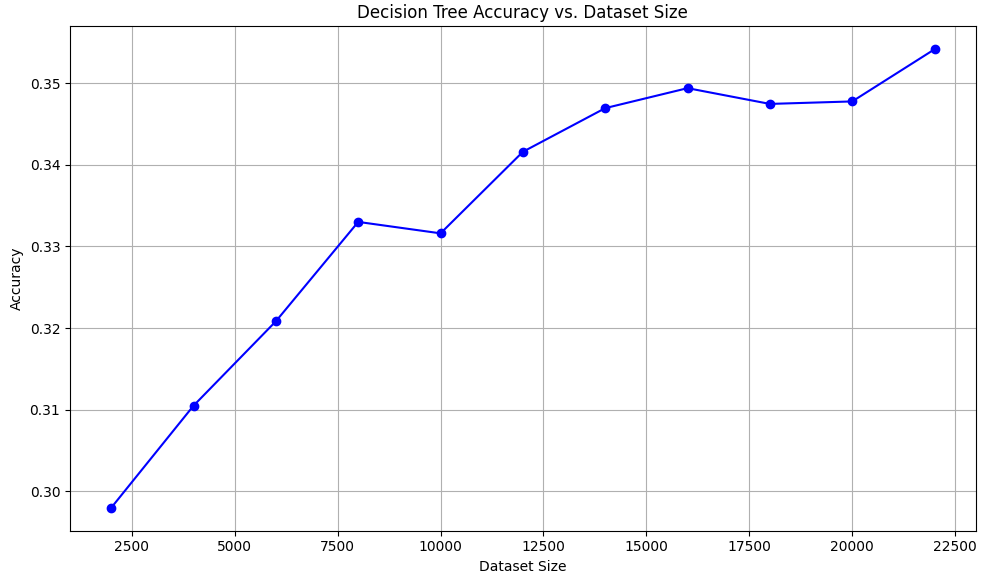

Game stats

Human vs MCTS: 0%-100%

Decision Tree vs MCTS: 0%-100%

Decision Tree vs Decision tree: Not possible

### MCTS Statistics

MCTS (100 000) vs MCTS (100 000)
1: 19, 2: 0, draws: 1, games: 20

MCTS (10 000) vs MCTS (100 000)
1: 8, 2: 0, draws: 2, games: 10

MCTS (1 000) vs MCTS (100 000)
1: 30, 2: 0, draws: 0, games: 30

MCTS (1 000) vs MCTS (10 000)
1: 26, 2: 0, draws: 4, games: 30

This is to be expected as Connect4 is a solved game for the 1st player from the initial position. This also reveals that MCTS has great evaluations for small sizes of rollouts in this context.

**Problem**: The Decision Tree cannot play against itself because it doesnt now when a column is already full and so it keeps playing illegal moves.

We found out that a MCTS with 1000 iterations wins in ALL GAMES against a MCTS with 100k iterations when it starts first.

We then figured that the dataset generation could be done with MCTS with 1000 iterations and thus generate a much larger dataset in a way shorter ammount of time.

We then decided to train the Decision Tree again but with this dataset to figure if it would have any changes in the accuray of the model.

In this project, we successfully implemented a Connect Four game with AI agents using Monte Carlo Tree Search (MCTS) and Decision Tree algorithms. The MCTS algorithm demonstrated strong performance in playing Connect Four, showcasing its ability to effectively explore the game tree and make informed decisions. The Decision Tree agent's performance, however, was heavily influenced by the structure of the training dataset. Representing the board state as individual position attributes significantly improved the Decision Tree's accuracy, indicating the importance of feature engineering in this context.

Despite achieving improved accuracy with the restructured dataset, the Decision Tree agent exhibited a critical limitation: it struggled to identify and avoid illegal moves. This constraint makes it unsuitable for scenarios where the agent plays against itself or another imperfect player, as it cannot inherently enforce game rules.

While a sufficiently large and well-structured dataset could enable the Decision Tree to mimic strong play, its inability to handle illegal moves restricts its applicability. In contrast, MCTS, with its game logic integration, provides a more robust and versatile solution for Connect Four AI.